In [1]:
!pip install transformers

In [2]:
import math
import torch
import torch.nn as nn
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, h, d_model):
        super().__init__()
        self.h = h
        self.d_model = d_model
        self.W_Q = nn.Linear(d_model, d_model, bias=True)
        self.W_K = nn.Linear(d_model, d_model, bias=True)
        self.W_V = nn.Linear(d_model, d_model, bias=True)
        self.W_T = nn.Linear(d_model, d_model, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None):
        Q, K, V = self.W_Q(q), self.W_K(k), self.W_V(v)
        Q, K, V = map(self.split_head, [Q, K, V])
        output, _ = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.concat_multihead(output)
        return self.W_T(output)

    def split_head(self, x):
        batch_size, seq_len, dim = x.size()
        head_dim = dim // self.h
        return x.view(batch_size, seq_len, self.h, head_dim).transpose(1, 2)

    def concat_multihead(self, x):
        batch_size, n_head, seq_len, d_v = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, d_v * n_head)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        batch_size, h, seq_len, d_k = K.size()
        score = (Q @ K.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            score = score.masked_fill(mask == 0, -1e4)
        score = self.softmax(score)
        return score @ V, score

class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)
        return self.gamma * (x - mean) / torch.sqrt(var + self.eps) + self.beta

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_hidden, d_model, device,p=0.1):
        super().__init__()
        self.layer1 = nn.Linear(d_model, d_hidden)
        self.layer2 = nn.Linear(d_hidden, d_model)
        self.dropout = nn.Dropout(p=p)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer2(self.dropout(self.relu(self.layer1(x))))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_hidden, h, drop_prob):
        super().__init__()
        self.attention = MultiHeadSelfAttention(h, d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.layer_norm1 = LayerNorm(d_model)
        self.ffn = PositionwiseFeedForward(d_hidden, d_model, drop_prob)
        self.dropout2 = nn.Dropout(p=drop_prob)
        self.layer_norm2 = LayerNorm(d_model)

    def forward(self, x, src_mask):
        _x = x
        x = self.attention(q=x, k=x, v=x, mask=src_mask)
        x = self.layer_norm1(_x + self.dropout1(x))
        _x = x
        x = self.ffn(x)
        return self.layer_norm2(_x + self.dropout2(x))

class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model, device):
        super().__init__()
        self.encoding = nn.Parameter(torch.zeros(max_len, d_model, device=device))
        nn.init.normal_(self.encoding, mean=0, std=0.02)

    def forward(self, x):
        batch_size, seq_len = x.size()
        return self.encoding[:seq_len, :].expand(batch_size, -1, -1)

class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len, drop_prob, device, segment_vocab_size=2):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.segment_embedding = nn.Embedding(segment_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(max_len, d_model, device)
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x, segment_ids):
        x = self.token_emb(x) + self.segment_embedding(segment_ids) + self.pos_encoding(x)
        x = self.layer_norm(x)
        return self.dropout(x)

class Encoder(nn.Module):
    def __init__(self, enc_voc_size, max_len, d_model, d_hidden, h, n_layers, drop_prob, device):
        super().__init__()
        self.emb = TransformerEmbedding(enc_voc_size, d_model, max_len, drop_prob, device)
        self.layers = nn.ModuleList([EncoderLayer(d_model, d_hidden, h, drop_prob) for _ in range(n_layers)])
        self.dense = nn.Linear(d_model, d_model)
    def forward(self, x, src_mask, segment_ids):
        x = self.emb(x, segment_ids)
        for layer in self.layers:
            x = layer(x, src_mask)
        return self.dense(x)

class BertForQA(nn.Module):
    def __init__(self, encoder, hidden_size=768):
        super().__init__()
        self.encoder = encoder
        self.qa_outputs = nn.Linear(hidden_size, 2)

    def forward(self, input_ids, attention_mask, token_type_ids,start_positions=None,
        end_positions=None):
        encoder_output = self.encoder(input_ids, attention_mask, token_type_ids)
        logits = self.qa_outputs(encoder_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        outputs = (start_logits, end_logits)

        if start_positions is not None and end_positions is not None:
            loss_fct = nn.CrossEntropyLoss()
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2
            outputs = (total_loss,) + outputs

        return outputs






In [3]:
new_dict = {}
def load_pretrained_weights(model, pretrained_model, device):
    pretrained_dict = pretrained_model.state_dict()
    model_dict = model.state_dict()

    weight_mapping = {
        'embeddings.word_embeddings.weight': 'encoder.emb.token_emb.weight',
        'embeddings.token_type_embeddings.weight': 'encoder.emb.segment_embedding.weight',
        'embeddings.position_embeddings.weight': 'encoder.emb.pos_encoding.encoding',
        'embeddings.LayerNorm.weight':'encoder.emb.layer_norm.weight',
        'embeddings.LayerNorm.bias':'encoder.emb.layer_norm.bias',
        'pooler.dense.weight': 'encoder.dense.weight',
        'pooler.dense.bias': 'encoder.dense.bias',
    }

    for i in range(12):
        prefix = f'encoder.layer.{i}'
        custom_prefix = f'encoder.layers.{i}'
        weight_mapping.update({
            f'{prefix}.attention.self.query.weight': f'{custom_prefix}.attention.W_Q.weight',
            f'{prefix}.attention.self.query.bias': f'{custom_prefix}.attention.W_Q.bias',
            f'{prefix}.attention.self.key.weight': f'{custom_prefix}.attention.W_K.weight',
            f'{prefix}.attention.self.key.bias': f'{custom_prefix}.attention.W_K.bias',
            f'{prefix}.attention.self.value.weight': f'{custom_prefix}.attention.W_V.weight',
            f'{prefix}.attention.self.value.bias': f'{custom_prefix}.attention.W_V.bias',
            f'{prefix}.attention.output.dense.weight': f'{custom_prefix}.attention.W_T.weight',
            f'{prefix}.attention.output.dense.bias': f'{custom_prefix}.attention.W_T.bias',
            f'{prefix}.attention.output.LayerNorm.weight': f'{custom_prefix}.layer_norm1.gamma',
            f'{prefix}.attention.output.LayerNorm.bias': f'{custom_prefix}.layer_norm1.beta',
            f'{prefix}.intermediate.dense.weight': f'{custom_prefix}.ffn.layer1.weight',
            f'{prefix}.intermediate.dense.bias': f'{custom_prefix}.ffn.layer1.bias',
            f'{prefix}.output.dense.weight': f'{custom_prefix}.ffn.layer2.weight',
            f'{prefix}.output.dense.bias': f'{custom_prefix}.ffn.layer2.bias',
            f'{prefix}.output.LayerNorm.weight': f'{custom_prefix}.layer_norm2.gamma',
            f'{prefix}.output.LayerNorm.bias': f'{custom_prefix}.layer_norm2.beta',
        })

    mapped_count = 0
    mapped_keys = set()
    for pretrained_key, custom_key in weight_mapping.items():
        if pretrained_key in pretrained_dict and custom_key in model_dict:
            new_dict[custom_key] = pretrained_dict[pretrained_key]
            mapped_count += 1
            mapped_keys.add(pretrained_key)

    model_dict.update(new_dict)
    model.load_state_dict(model_dict)
    unmapped_pretrained = set(pretrained_dict.keys()) - mapped_keys
    unmapped_model = set(model_dict.keys()) - set(weight_mapping.values())

    print(f"\nTotal mapped weights: {mapped_count}/{len(weight_mapping)}")
    print("\nUnmapped Pretrained Parameters:")
    print(unmapped_pretrained)
    print("\nUnmapped Model Parameters:")
    print(unmapped_model)




    return model.to(device)

In [4]:
from transformers import BertModel
from transformers import AutoTokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

encoder = Encoder(
    enc_voc_size=tokenizer.vocab_size,
    max_len=512,
    d_model=768,
    d_hidden=3072,
    h=12,
    n_layers=12,
    drop_prob=0.1,
    device=device
)
model = BertForQA(encoder)

pretrained_bert = BertModel.from_pretrained('bert-base-uncased')
model = load_pretrained_weights(model, pretrained_bert, device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Total mapped weights: 199/199

Unmapped Pretrained Parameters:
set()

Unmapped Model Parameters:
{'qa_outputs.bias', 'qa_outputs.weight'}


In [6]:
print(model.state_dict().keys())

odict_keys(['encoder.emb.token_emb.weight', 'encoder.emb.segment_embedding.weight', 'encoder.emb.pos_encoding.encoding', 'encoder.emb.layer_norm.weight', 'encoder.emb.layer_norm.bias', 'encoder.layers.0.attention.W_Q.weight', 'encoder.layers.0.attention.W_Q.bias', 'encoder.layers.0.attention.W_K.weight', 'encoder.layers.0.attention.W_K.bias', 'encoder.layers.0.attention.W_V.weight', 'encoder.layers.0.attention.W_V.bias', 'encoder.layers.0.attention.W_T.weight', 'encoder.layers.0.attention.W_T.bias', 'encoder.layers.0.layer_norm1.gamma', 'encoder.layers.0.layer_norm1.beta', 'encoder.layers.0.ffn.layer1.weight', 'encoder.layers.0.ffn.layer1.bias', 'encoder.layers.0.ffn.layer2.weight', 'encoder.layers.0.ffn.layer2.bias', 'encoder.layers.0.layer_norm2.gamma', 'encoder.layers.0.layer_norm2.beta', 'encoder.layers.1.attention.W_Q.weight', 'encoder.layers.1.attention.W_Q.bias', 'encoder.layers.1.attention.W_K.weight', 'encoder.layers.1.attention.W_K.bias', 'encoder.layers.1.attention.W_V.weigh

In [ ]:
print(pretrained_bert.state_dict().keys())

odict_keys(['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.1.attention.self.query.weight', 'encoder.layer.1.attention.self.query.bi

In [ ]:
print(new_dict_keys)

odict_keys(['encoder.emb.token_emb.weight', 'encoder.emb.segment_embedding.weight', 'encoder.emb.pos_encoding.encoding', 'encoder.layers.0.attention.W_Q.weight', 'encoder.layers.0.attention.W_Q.bias', 'encoder.layers.0.attention.W_K.weight', 'encoder.layers.0.attention.W_K.bias', 'encoder.layers.0.attention.W_V.weight', 'encoder.layers.0.attention.W_V.bias', 'encoder.layers.0.attention.W_T.weight', 'encoder.layers.0.attention.W_T.bias', 'encoder.layers.0.layer_norm1.gamma', 'encoder.layers.0.layer_norm1.beta', 'encoder.layers.0.ffn.layer1.weight', 'encoder.layers.0.ffn.layer1.bias', 'encoder.layers.0.ffn.layer2.weight', 'encoder.layers.0.ffn.layer2.bias', 'encoder.layers.0.layer_norm2.gamma', 'encoder.layers.0.layer_norm2.beta', 'encoder.layers.1.attention.W_Q.weight', 'encoder.layers.1.attention.W_Q.bias', 'encoder.layers.1.attention.W_K.weight', 'encoder.layers.1.attention.W_K.bias', 'encoder.layers.1.attention.W_V.weight', 'encoder.layers.1.attention.W_V.bias', 'encoder.layers.1.att

In [ ]:
print("\nToken Embedding Weights:")
print(model.state_dict().get('encoder.emb.segment_embedding.weight'))


Token Embedding Weights:
tensor([[ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
        [ 0.0011, -0.0030, -0.0032,  ...,  0.0047, -0.0052, -0.0112]],
       device='cuda:0')


In [ ]:
print("\nToken Embedding Weights:")
print(pretrained_bert.state_dict().get('embeddings.token_type_embeddings.weight'))


Token Embedding Weights:
tensor([[ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
        [ 0.0011, -0.0030, -0.0032,  ...,  0.0047, -0.0052, -0.0112]])


In [ ]:


print(len(model.state_dict().keys()))


201


In [ ]:
print(len(pretrained_bert.state_dict().keys()))

199


In [ ]:
print(len(new_dict_keys))

199


In [5]:
!pip install datasets
from datasets import load_dataset

In [6]:
squad=load_dataset("squad")

README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [45]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [46]:
train_subset = squad["train"].select(range(9000))
train_dataset = train_subset.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=squad["train"].column_names,
)
len(squad["train"]), len(train_dataset)

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

(87599, 9137)

In [47]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [48]:

validation_subset = squad["validation"].select(range(1100))

validation_dataset = validation_subset.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=squad["validation"].column_names,
)
len(squad["validation"]), len(validation_dataset)

Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

(10570, 1123)

In [51]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=29,
)
eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=29
)

In [50]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [52]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00


In [53]:
import numpy as np
import collections
import evaluate

from tqdm.auto import tqdm

metric = evaluate.load("squad")



def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)
    n_best = 20
    max_answer_length = 30
    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]



    return metric.compute(predictions=predicted_answers, references=theoretical_answers)



In [54]:
from tqdm import tqdm


def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    correct_start = 0
    correct_end = 0
    total_samples = 0
    for batch in tqdm(dataloader, desc="Training"):
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)
        # Ensure target tensors are 1D
        start_positions = start_positions.view(-1) # Reshape start_positions
        end_positions = end_positions.view(-1)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,start_positions=start_positions, end_positions=end_positions)
        loss, start_logits, end_logits = outputs[0], outputs[1], outputs[2]

        # Compute loss
        start_loss = loss_fn(start_logits, start_positions)
        end_loss = loss_fn(end_logits, end_positions)
        loss = (start_loss + end_loss) / 2

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Compute accuracy
        start_preds = torch.argmax(start_logits, dim=-1)
        end_preds = torch.argmax(end_logits, dim=-1)
        correct_start += (start_preds == start_positions).sum().item()
        correct_end += (end_preds == end_positions).sum().item()
        total_samples += start_positions.size(0)


    avg_loss = total_loss / len(dataloader)
    start_accuracy = correct_start / total_samples
    end_accuracy = correct_end / total_samples
    avg_accuracy = (start_accuracy + end_accuracy) / 2
    return avg_loss, avg_accuracy



# Training loop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForQA(
  (encoder): Encoder(
    (emb): TransformerEmbedding(
      (token_emb): Embedding(30522, 768)
      (segment_embedding): Embedding(2, 768)
      (pos_encoding): PositionalEncoding()
      (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-11): 12 x EncoderLayer(
        (attention): MultiHeadSelfAttention(
          (W_Q): Linear(in_features=768, out_features=768, bias=True)
          (W_K): Linear(in_features=768, out_features=768, bias=True)
          (W_V): Linear(in_features=768, out_features=768, bias=True)
          (W_T): Linear(in_features=768, out_features=768, bias=True)
          (softmax): Softmax(dim=-1)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (layer_norm1): LayerNorm()
        (ffn): PositionwiseFeedForward(
          (layer1): Linear(in_features=768, out_features=3072, bias=True)
          (layer2): Linear(in_features=3072, out

In [59]:

def evaluate(model, dataloader):
    model.eval()
    start_logits, end_logits = [], []
    for batch in tqdm(eval_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            result = model(input_ids=input_ids,
                           attention_mask=attention_mask, token_type_ids=token_type_ids)

        start_logits.append(result[0].cpu().numpy())
        end_logits.append(result[1].cpu().numpy())



    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)

    return start_logits, end_logits



train_accuracies = []

# Training loop
num_epochs = 30
train_losses = []
all_train_losses = []
f1_scores = [] 


In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn, device)
    print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    start_logits,end_logits=evaluate(model,eval_dataloader)
    metrics_ = compute_metrics(start_logits, end_logits, validation_dataset, squad["validation"])
    print(f"Exact Match (EM): {metrics_['exact_match']}, F1 Score: {metrics_['f1']}")
    f1_scores.append(metrics_["f1"]) 

    
    

Epoch 1/30


Training: 100%|██████████| 316/316 [06:02<00:00,  1.15s/it]


Training Loss: 3.234174742728849, Training Accuracy: 0.2507387545146109


100%|██████████| 10570/10570 [00:02<00:00, 4867.56it/s]


Exact Match (EM): 4.910122989593188, F1 Score: 5.814506837606535
Epoch 2/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 1.6708189403708977, Training Accuracy: 0.5549414468643975


100%|██████████| 10570/10570 [00:02<00:00, 4929.86it/s]


Exact Match (EM): 7.06717123935667, F1 Score: 7.782099182942101
Epoch 3/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 1.085850625664373, Training Accuracy: 0.6891758782970341


100%|██████████| 10570/10570 [00:02<00:00, 4810.17it/s]


Exact Match (EM): 7.2374645222327345, F1 Score: 7.953814056884087
Epoch 4/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.15s/it]


Training Loss: 0.7840650608833832, Training Accuracy: 0.7596038086899419


100%|██████████| 10570/10570 [00:02<00:00, 4858.39it/s] 


Exact Match (EM): 7.492904446546831, F1 Score: 8.089581327896262
Epoch 5/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.15s/it]


Training Loss: 0.5651980588047565, Training Accuracy: 0.8198533435482106


100%|██████████| 10570/10570 [00:02<00:00, 4670.57it/s]


Exact Match (EM): 7.341532639545885, F1 Score: 8.00764871784213
Epoch 6/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.15s/it]


Training Loss: 0.42864041169515893, Training Accuracy: 0.8562438437123783


100%|██████████| 10570/10570 [00:02<00:00, 4899.80it/s]


Exact Match (EM): 7.559129612109745, F1 Score: 8.231778349663363
Epoch 7/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.15s/it]


Training Loss: 0.3117996850021514, Training Accuracy: 0.8934004596694758


100%|██████████| 10570/10570 [00:02<00:00, 4937.73it/s]


Exact Match (EM): 7.634815515610217, F1 Score: 8.240490923060282
Epoch 8/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.15s/it]


Training Loss: 0.24079127740586484, Training Accuracy: 0.9170953266936631


100%|██████████| 10570/10570 [00:02<00:00, 4860.45it/s] 


Exact Match (EM): 7.540208136234626, F1 Score: 8.180623733700372
Epoch 9/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.15s/it]


Training Loss: 0.1833389449416648, Training Accuracy: 0.9367407245266499


100%|██████████| 10570/10570 [00:02<00:00, 4815.23it/s] 


Exact Match (EM): 7.530747398297067, F1 Score: 8.164459406273373
Epoch 10/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.15s/it]


Training Loss: 0.16045820139734593, Training Accuracy: 0.9456605012586188


100%|██████████| 10570/10570 [00:02<00:00, 4991.54it/s]


Exact Match (EM): 7.549668874172186, F1 Score: 8.147412564343036
Epoch 11/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.15s/it]


Training Loss: 0.14078664007637934, Training Accuracy: 0.9518441501586954


100%|██████████| 10570/10570 [00:02<00:00, 4912.19it/s]


Exact Match (EM): 7.483443708609271, F1 Score: 8.142540162617573
Epoch 12/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.15s/it]


Training Loss: 0.11284423459327154, Training Accuracy: 0.9611469847871292


100%|██████████| 10570/10570 [00:02<00:00, 4873.96it/s]


Exact Match (EM): 7.6158940397351, F1 Score: 8.24569366893486
Epoch 13/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.09975727211648622, Training Accuracy: 0.9638283900623836


100%|██████████| 10570/10570 [00:02<00:00, 4804.43it/s]


Exact Match (EM): 7.578051087984862, F1 Score: 8.209520563958906
Epoch 14/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.08368011218086004, Training Accuracy: 0.9709423224253038


100%|██████████| 10570/10570 [00:02<00:00, 4932.50it/s]


Exact Match (EM): 7.5685903500473035, F1 Score: 8.2171377882014
Epoch 15/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.08089689857435495, Training Accuracy: 0.9714895479916822


100%|██████████| 10570/10570 [00:02<00:00, 4841.77it/s]


Exact Match (EM): 7.464522232734153, F1 Score: 8.152626071492467
Epoch 16/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.07557591916831163, Training Accuracy: 0.974718178833315


100%|██████████| 10570/10570 [00:02<00:00, 4826.85it/s] 


Exact Match (EM): 7.6158940397351, F1 Score: 8.26156153972651
Epoch 17/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.070255655016532, Training Accuracy: 0.9762504104191748


100%|██████████| 10570/10570 [00:02<00:00, 4861.49it/s]


Exact Match (EM): 7.644276253547777, F1 Score: 8.310418517980516
Epoch 18/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.05830689720865457, Training Accuracy: 0.9812848856298566


100%|██████████| 10570/10570 [00:02<00:00, 4935.48it/s]


Exact Match (EM): 7.663197729422895, F1 Score: 8.330195561582215
Epoch 19/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.059188069237095506, Training Accuracy: 0.980464047280289


100%|██████████| 10570/10570 [00:02<00:00, 4932.96it/s]


Exact Match (EM): 7.701040681173131, F1 Score: 8.306742714277762
Epoch 20/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.06033967311203567, Training Accuracy: 0.9805734923935646


100%|██████████| 10570/10570 [00:02<00:00, 4927.73it/s]


Exact Match (EM): 7.738883632923368, F1 Score: 8.337859596434887
Epoch 21/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.05223657624262586, Training Accuracy: 0.9834737878953704


100%|██████████| 10570/10570 [00:02<00:00, 4894.03it/s]


Exact Match (EM): 7.6726584673604545, F1 Score: 8.340854296839014
Epoch 22/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.05311391731323321, Training Accuracy: 0.9817773886395973


100%|██████████| 10570/10570 [00:02<00:00, 4933.82it/s]


Exact Match (EM): 7.587511825922422, F1 Score: 8.272718325021561
Epoch 23/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.0438181232960152, Training Accuracy: 0.985060742037868


100%|██████████| 10570/10570 [00:02<00:00, 4935.34it/s]


Exact Match (EM): 7.767265846736046, F1 Score: 8.373421307105925
Epoch 24/30


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.03571403350885898, Training Accuracy: 0.9881799277662253


100%|██████████| 10570/10570 [00:02<00:00, 4805.76it/s] 


Exact Match (EM): 7.748344370860927, F1 Score: 8.429232582209925
Epoch 25/30


Training:  19%|█▉        | 61/316 [01:10<04:52,  1.15s/it]

In [66]:
num_epochs=6
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn, device)
    print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    start_logits,end_logits=evaluate(model,eval_dataloader)
    metrics_ = compute_metrics(start_logits, end_logits, validation_dataset, squad["validation"])
    print(f"Exact Match (EM): {metrics_['exact_match']}, F1 Score: {metrics_['f1']}")
    f1_scores.append(metrics_["f1"])

Epoch 1/6


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.03410617362164827, Training Accuracy: 0.9890007661157929


100%|██████████| 10570/10570 [00:02<00:00, 4965.05it/s]


Exact Match (EM): 7.805108798486282, F1 Score: 8.47260415859948
Epoch 2/6


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.031736123762417676, Training Accuracy: 0.9894385465688957


100%|██████████| 10570/10570 [00:02<00:00, 4980.02it/s]


Exact Match (EM): 7.701040681173131, F1 Score: 8.406621238486785
Epoch 3/6


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.02666911688895566, Training Accuracy: 0.9908613330414797


100%|██████████| 10570/10570 [00:02<00:00, 4958.83it/s]


Exact Match (EM): 7.691579943235572, F1 Score: 8.3447745920462
Epoch 4/6


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.04282533720871021, Training Accuracy: 0.9860457480573492


100%|██████████| 10570/10570 [00:02<00:00, 4946.76it/s]


Exact Match (EM): 7.653736991485336, F1 Score: 8.291627280250221
Epoch 5/6


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.031022709254632245, Training Accuracy: 0.9900404946919119


100%|██████████| 10570/10570 [00:02<00:00, 4844.02it/s] 


Exact Match (EM): 7.5685903500473035, F1 Score: 8.219976093079325
Epoch 6/6


Training: 100%|██████████| 316/316 [06:01<00:00,  1.14s/it]


Training Loss: 0.023360518115197598, Training Accuracy: 0.9926671774105287


100%|██████████| 10570/10570 [00:02<00:00, 4878.29it/s]


Exact Match (EM): 7.757805108798486, F1 Score: 8.36118154458966


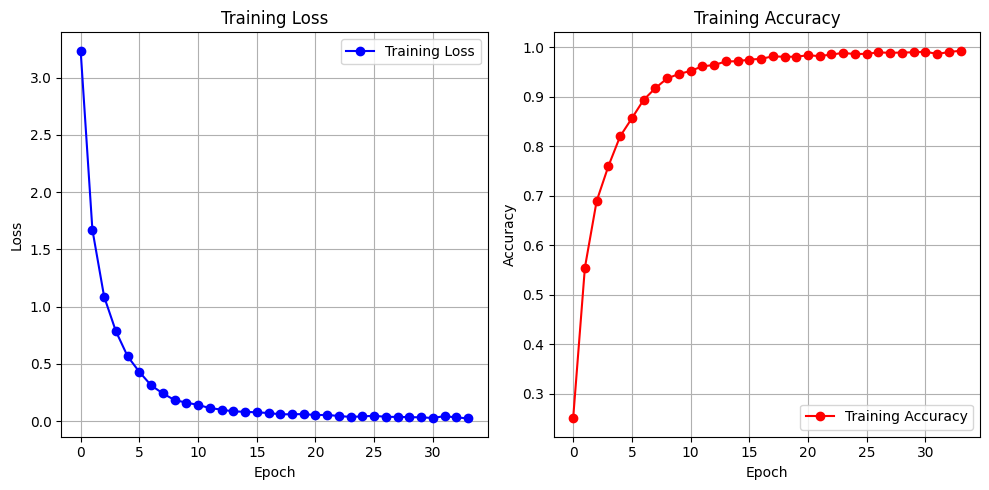

In [68]:
plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-o', label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'r-o', label='Training Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

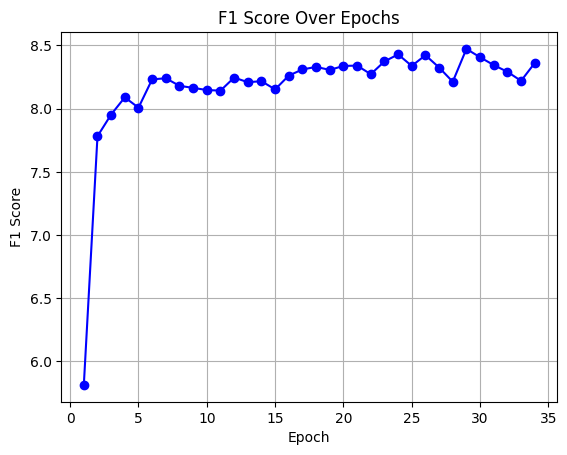

In [69]:
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score Over Epochs")
plt.grid()
plt.show()

In [89]:
def predict_answer(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)
    n_best = 20
    max_answer_length = 30
    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]

    first_example = examples[100]
    first_pred = predicted_answers[100]

    print("\n--- First Example ---")
    print(f"**Context:** {first_example['context']}\n")
    print(f"**Question:** {first_example['question']}\n")
    print(f"**Predicted Answer:** {first_pred['prediction_text']}\n")
    print(f"**Theoretical Answer:** {first_example['answers']}\n")

In [90]:
predict_answer(start_logits, end_logits, validation_dataset, squad["validation"])

100%|██████████| 10570/10570 [00:02<00:00, 4762.05it/s]



--- First Example ---
**Context:** CBS broadcast Super Bowl 50 in the U.S., and charged an average of $5 million for a 30-second commercial during the game. The Super Bowl 50 halftime show was headlined by the British rock group Coldplay with special guest performers Beyoncé and Bruno Mars, who headlined the Super Bowl XLVII and Super Bowl XLVIII halftime shows, respectively. It was the third-most watched U.S. broadcast ever.

**Question:** Who were special guests for the Super Bowl halftime show?

**Predicted Answer:** Beyoncé and Bruno Mars

**Theoretical Answer:** {'text': ['Beyoncé and Bruno Mars', 'Beyoncé and Bruno Mars', 'Beyoncé and Bruno Mars'], 'answer_start': [233, 233, 233]}



In [94]:
import os

def save_predictions_to_file(start_logits, end_logits, features, examples, filename="predictions.txt"):
    predicted_answers, theoretical_answers = predict_answer(start_logits, end_logits, features, examples)
    
    # Create output directory if it doesn't exist
    os.makedirs('/kaggle/working', exist_ok=True)
    
    # Save to Kaggle working directory
    filepath = os.path.join('/kaggle/working', filename)
    
    with open(filepath, "w", encoding="utf-8") as f:
        for i in range(1100):
            f.write("\n" + "="*100 + "\n")
            f.write(f"Example {i+1}/{len(examples)}\n")
            f.write(f"ID: {theoretical_answers[i]['id']}\n")
            f.write(f"Question: {examples[i]['question']}\n")
            f.write(f"Context: {examples[i]['context'][:200]}...\n")
            f.write("\nTheoretical Answer(s):\n")
            for ans in theoretical_answers[i]['answers']['text']:
                f.write(f" - {ans}\n")
            f.write(f"\nPredicted Answer: {predicted_answers[i]['prediction_text']}\n")
            f.write("="*100 + "\n")
    
    print(f"Predictions saved to: {filepath}")

# Usage
save_predictions_to_file(start_logits, end_logits, validation_dataset, squad["validation"])

100%|██████████| 10570/10570 [00:02<00:00, 4879.58it/s]


Predictions saved to: /kaggle/working/predictions.txt


In [74]:
checkpoint_path = '/kaggle/working/model_optimizer.pth'  # Kaggle working directory
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}
torch.save(checkpoint, checkpoint_path)

print(f"Model and optimizer checkpoint saved to: {checkpoint_path}")


Model and optimizer checkpoint saved to: /kaggle/working/model_optimizer.pth
